<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [189]:
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
import scipy.stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from covid_simulation.preprocessing.andalucia import download_df_andalucia


URL_ANDALUCIA = "https://www.juntadeandalucia.es/institutodeestadisticaycartografia/badea/stpivot/stpivot/Print?cube=a2a26120-d774-4fe0-b3f1-202eb541551f&type=3&foto=si&ejecutaDesde=&codConsulta=38228&consTipoVisua=JP"

df = download_as_dataframe(URL_ANDALUCIA)
df['dia'] = df.index
df = df.reset_index(drop=True)


from covid_simulation.noise.noise import get_quantiles
from covid_simulation.plot_utils import plot_prediction_with_uncertainty
from covid_simulation.simulation.sampling import noise_on_cases
from covid_simulation.simulation.sampling import noise_on_times
from covid_simulation.simulation.sampling import propagate_times_hospital
from covid_simulation.simulation.sim_filling import simulate_bed_filling
from covid_simulation.simulation.utils import from_counts_to_times

dic_names = {"uci_in_diary": "Ingresos UCI diarios",
             "uci_in": "Ingresos UCI acumulados",
             "uci_active": "Camas ocupadas en UCI",
             "hosp_in": "Ingresos no UCI acumulados",
             "hosp_in_diary": "Ingresos no UCI diarios",
             "hosp_active": "Camas ocupadas no UCI"
             }

dic_cmap = {"uci_in_diary": "Oranges",
            "uci_in": "Reds",
            "uci_active": "Greens",
            "hosp_in": "Greens",
            "hosp_in_diary": "Blues",
            "hosp_active": "Purples"}


In [221]:
from covid_simulation.simulation.distributions import PARAMS_PROB_UCI

In [222]:
PARAMS_PROB_UCI

{'p_uci': 0.12, 'p_uci_now_given_uci': 0.25}

In [225]:
def perform_simulations_and_store_(df, region,nruns=500, max_beds_uci=None, max_beds_hosp=None,
                                  path_csv=None, plots=False,
                                  p_uci=None, p_uci_now_given_uci=None,
                                  path_plots=None, verbose=True,
                                  **kwargs):
    """
    Do the whole simulation process:
        - Convert daily cases to acumulate
        - Add noise (different to each simulation)
        - Compute the times and LOS for each simulation
        - Simulate bed filling both in hospital and UCI
        - Store cases and metrics in csv
        - Store plots

    Parameters
    ---------------
    df : pandas.DataFrame
        size : (ndays, *)
        Dataframe containing the number of different cases by day.
        Its index must be the date.
        It must contain an "ingreso" (admitted) column.
        It must also contain a "region" (region) column.
        * = Number of columns. They are be types of cases (admitted, uci...)
    nruns : int
        Number of runs to sample.
    max_beds_uci : int or None
        Maximum number of beds in UCI. If None, there is no limit
    max_beds_hosp: int or None
        Maximum number of beds in hospital. If None, there is no limit
    path_csv : str
        Path where to store the output csv, containing different cases
        (admitted, occupancy...) and metrics for each (median, quantiles)
    region : str
        Region of interest (Autonomous Community or province)
    p_uci : float or None, default=None
        Probability of going to UCI from hospital.
        If None, it uses values from PARAMS_PROB_UCI
    p_uci_now_given_uci : float or None, default=None
        Probability of going to UCI directly, given you go to UCI.
        If None, it uses values from PARAMS_PROB_UCI
    path_plots : str, Path or None, default = None
        Path where to store the output plots, in png format.
        If None, no plot is outputted.
    **kwargs
        This argument is added to avoid conflicts when passing
        non-used extra parameters via **dictionaries.

    Returns
    -------------
    None
    """
    df = df.copy()
    df = df[df['region'] == region]
    df = df.sort_values('dia', ignore_index=True)
    # Calculate cumulative of admitted patients
    y = df["ingreso"]
    x = y.reset_index().index

    if verbose:
        print('\nSampling from number of people and random arrival distributions...')
    y_noise = noise_on_cases(y, nruns=nruns)
    times = from_counts_to_times(x, y_noise)
    times = noise_on_times(times)
    if verbose:
        print('Done!')
        print('\nSampling from length of stay distributions...')
    (times_hosp_in, times_hosp_out, times_uci_in,
     times_uci_out) = propagate_times_hospital(times,
                                               p_uci=p_uci,
                                               p_uci_now_given_uci=p_uci_now_given_uci)
    if verbose:
        print('Done!')
        print('\nImposing max beds contraint in UCI...')
    uci_in, uci_out, uci_active = simulate_bed_filling(x,
                                                       times_uci_in,
                                                       times_uci_out,
                                                       beds_max=max_beds_uci,
                                                       verbose=verbose,
                                                       try_heuristic=True)
    if verbose:
        print('Done!')
        print('\nImposing max beds contraint in hospital...')

    hosp_in, hosp_out, hosp_active = simulate_bed_filling(x,
                                                          times_hosp_in,
                                                          times_hosp_out,
                                                          beds_max=max_beds_hosp,
                                                          verbose=verbose,
                                                          try_heuristic=True)
    if verbose:
        print('Done!')

    # Create path for plots if needed
    if path_plots is not None:
        if not os.path.exists(path_plots):
            os.mkdir(path_plots)

    # Get the list we want
    dic_arrays = {"uci_in": uci_in,
                  "uci_in_diary": np.diff(uci_in, axis=0, prepend=0),
                  "uci_active": uci_active,
                  "hosp_in": hosp_in,
                  "hosp_in_diary": np.diff(hosp_in, axis=0, prepend=0),
                  "hosp_active": hosp_active}

    # Get their metrics
    # Initialize a dictionary containing them
    dic_metrics = {}
    quantiles = (.05, .25, .75, .95)

    # Compute first and last date
    first_date = df["dia"].min()
    last_date = first_date + pd.Timedelta(days=x.shape[0] - 1)
    if plots:
        for name, quantity in dic_arrays.items():
            if name != 'uci_in':
                continue
            quan, median = get_quantiles(quantity, axis=1,
                                         quantiles=quantiles)

            # Add metrics to dictionary
            for i in range(len(quantiles)):
                q_name = f"q{int(100*quantiles[i])}"
                dic_metrics[(name, q_name)] = quan[i, :]
            dic_metrics[(name, "median")] = median


            # Plot them
            plt.figure(dpi=100)

            plot_prediction_with_uncertainty(x, median, quan,
                                             fecha_inicio=first_date,
                                             color="black",
                                             cmap=plt.get_cmap(dic_cmap[name]))

            # Add ground truth data points
            if name == "uci_in" and "uci" in df.columns:
                plt.plot(df["dia"], df["uci"], "k.", markersize=2)

            plt.title(region.capitalize())
            plt.xlabel('Fecha')
            plt.ylabel(dic_names[name])
            if path_plots is not None:
                plt.savefig(os.path.join(path_plots, name + ".png"))

    # Turn dictionary into a dataframe
    df_metrics = pd.DataFrame(dic_metrics)

    # Add dates
    df_metrics["date"] = pd.date_range(
        start=first_date, end=last_date, freq="D")
    df_metrics.set_index("date", inplace=True)
    
    if path_csv is not None:
        # Store dataframe
        df_metrics.to_csv(path_csv)
    
    
    # calculate log-likelihood
    _, median = get_quantiles(uci_in, axis=1,
                                         quantiles=())
    
#     hist = np.histogram(uci_in[-1,:],bins=20, density=True)
#     dist = scipy.stats.rv_histogram(hist)
    measured_point = df["uci"].to_numpy()[-1]
    distance = np.abs(median[-1]-measured_point)
#     loglk = dist.logpdf(measured_point)
#     if np.isfinite(loglk) is False:
#         loglk = -100
    if plots:
        x_max = max((uci_in[-1,:].max(), measured_point))
        x = np.arange(0,int(x_max*1.1),1)
        plt.figure()
        plt.plot(x,dist.pdf(x))
        plt.plot(measured_point,0,'o')
    print(median[-1])
    p_best = p_uci*(measured_point/median[-1])
    return p_best

In [228]:
dict_best_p0_ = {}

for region in df.region.unique():
    best_p = perform_simulations_and_store_(df, region, p_uci=0.12, plots=False,verbose=False, nruns=1000)
    dict_best_p0_[region] = best_p

21.0
594.0
53.0
54.0
8772.0
115.0
22.0
71.0
150.0
113.5


In [230]:
dict_best_p0_

{'almeria': 0.2,
 'andalucia': 0.13555555555555554,
 'cadiz': 0.16075471698113206,
 'cordoba': 0.13777777777777778,
 'españa': 0.10829001367989056,
 'granada': 0.12208695652173912,
 'huelva': 0.1636363636363636,
 'jaen': 0.10478873239436619,
 'malaga': 0.1248,
 'sevilla': 0.1459030837004405}

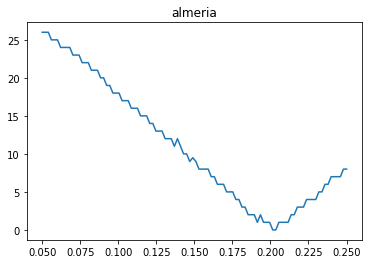

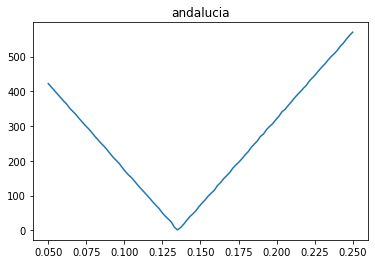

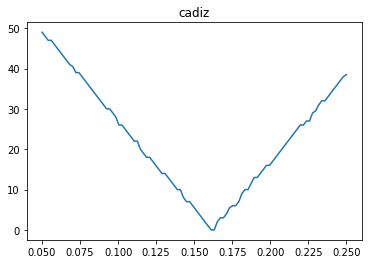

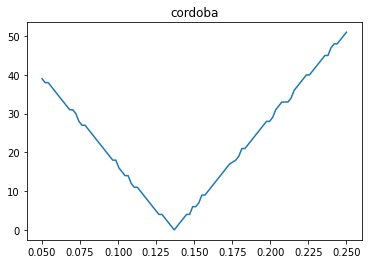

KeyboardInterrupt: 

In [201]:
dict_best_p0 = {}

for region in df.region.unique():

    metrics = []
    ps = np.linspace(0.05,.25,100)
    for p in ps:
        dist = perform_simulations_and_store_(df, region, p_uci=p, plots=False,verbose=False)
        metrics.append(dist)
    metrics = np.asarray(metrics)

    bestp = ps[metrics.argmin()]
    plt.title(region)
    plt.plot(ps,metrics)
    plt.show()
    dict_best_p0[region] = bestp

In [202]:
dict_best_p0

{'almeria': 0.20151515151515154,
 'andalucia': 0.13484848484848486,
 'cadiz': 0.1611111111111111,
 'cordoba': 0.13686868686868686}

In [142]:
from scipy.optimize import minimize_scalar, minimize

In [169]:
def sigmoid(x):
    return 1/(1 + np.exp(-x)) 

def inv_sigmoid(y):
    return np.log(y/(1-y))
x=.15
print(inv_sigmoid(sigmoid(x)),x)

0.15000000000000013 0.15


In [181]:
log_lks = []
ps = np.linspace(0.001,.999,200)
for p in ps:
    lk = perform_simulations_and_store_(df, 'almeria', p_uci=p, plots=False,verbose=False)
    log_lks.append(lk)
log_lks = np.asarray(log_lks)

/Users/danky/miniconda3/envs/covid/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1702: RuntimeWarning: divide by zero encountered in log
  return log(self._pdf(x, *args))
/Users/danky/miniconda3/envs/covid/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1702: RuntimeWarning: divide by zero encountered in log
  return log(self._pdf(x, *args))


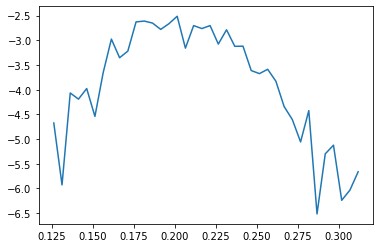

In [176]:
f = lambda x: -perform_simulations_and_store_(df, 'almeria', p_uci=sigmoid(x), plots=False,verbose=False)
sol = minimize(f,x0= inv_sigmoid(.15), )
sol

      fun: 3.7624912714571805
 hess_inv: array([[1]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 3
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([-1.73460106])

In [177]:
sigmoid(sol.x)

array([0.15])


Sampling from number of people and random arrival distributions...
Done!

Sampling from length of stay distributions...
Done!

Imposing max beds contraint in UCI...
Done!

Imposing max beds contraint in hospital...
Done!


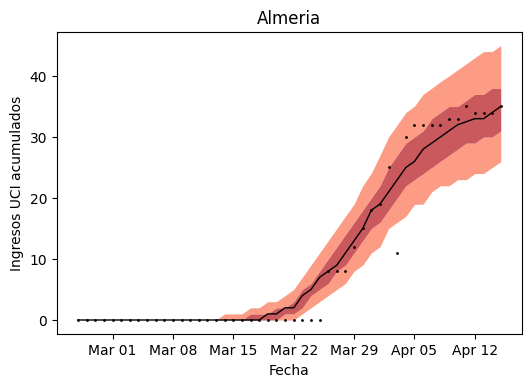

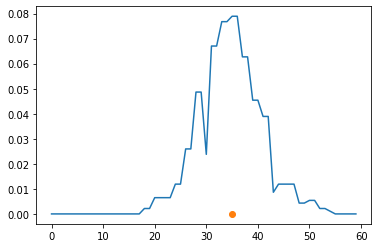

In [114]:
log_lk = 

In [106]:
log_lk

-inf

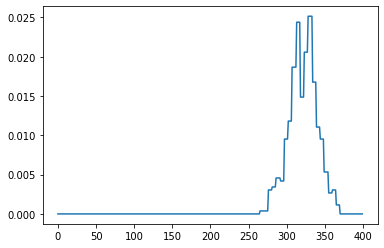

In [107]:
plt.plot(x,dist.pdf(x))

In [66]:
uci_in.shape

(49, 500)

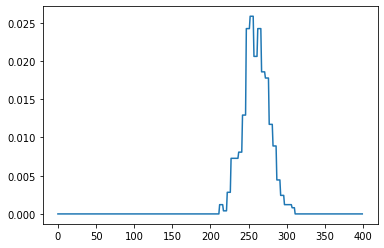

In [ ]:
dist.logpdf()